# Electricity Consumption Analysis

## Dataset Overview
The dataset contains the following columns:
- Date
- Time
- Global_active_power
- Global_reactive_power
- Voltage
- Global_intensity
- Sub_metering_1
- Sub_metering_2
- Sub_metering_3

---

## Setup and Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load the dataset
file_path = 'household_power_consumption.csv'
df = pd.read_csv(file_path, sep=';', low_memory=False, na_values=['?'])

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())

Dataset Shape: (2075259, 9)

First few rows:
         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
R

In [3]:
# Combine Date and Time into a single datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Drop original Date and Time columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Convert all other columns to numeric
for col in df.columns:
    if col != 'datetime':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Set datetime as index
df.set_index('datetime', inplace=True)

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Drop rows with missing values
df_clean = df.dropna()
print(f"\nDataset shape after cleaning: {df_clean.shape}")

Missing values per column:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Total missing values: 181853

Dataset shape after cleaning: (2049280, 7)


In [4]:
# Display cleaned data
print("Cleaned Dataset:")
print(df_clean.head(10))
print("\nDataset Statistics:")
print(df_clean.describe())

Cleaned Dataset:
                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
2006-12-16 17:29:00                3.520                  0.522   235.02   
2006-12-16 17:30:00                3.702                  0.520   235.09   
2006-12-16 17:31:00                3.700                  0.520   235.22   
2006-12-16 17:32:00                3.668                  0.510   233.99   
2006-12-16 17:33:00                3.662                  0.510   233.86   

                     Global_intensity  Sub_metering_1  Sub_metering_2 

---
## Task 1 — Exploratory Data Analysis (EDA)

### 1.1 Time-Series Trend Analysis

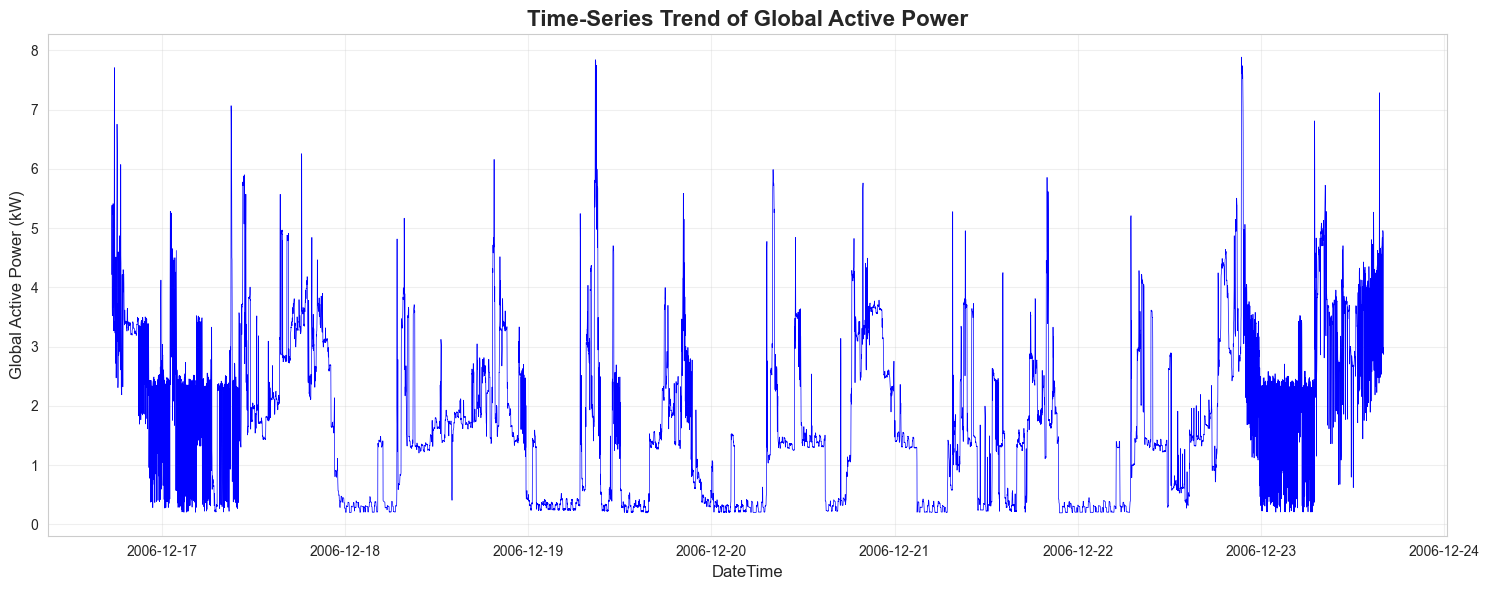

Global Active Power Statistics:
count    2.049280e+06
mean     1.091615e+00
std      1.057294e+00
min      7.600000e-02
25%      3.080000e-01
50%      6.020000e-01
75%      1.528000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64

Number of zero values: 0
Percentage of zero values: 0.00%


In [5]:
# Plot time-series trend of Global_active_power (sample first 10000 records for visibility)
sample_size = 10000
df_sample = df_clean.iloc[:sample_size]

plt.figure(figsize=(15, 6))
plt.plot(df_sample.index, df_sample['Global_active_power'], linewidth=0.5, color='blue')
plt.title('Time-Series Trend of Global Active Power', fontsize=16, fontweight='bold')
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Global Active Power (kW)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check for abnormal readings
print("Global Active Power Statistics:")
print(df_clean['Global_active_power'].describe())
print(f"\nNumber of zero values: {(df_clean['Global_active_power'] == 0).sum()}")
print(f"Percentage of zero values: {(df_clean['Global_active_power'] == 0).sum() / len(df_clean) * 100:.2f}%")

### 1.2 Daily and Hourly Patterns Analysis

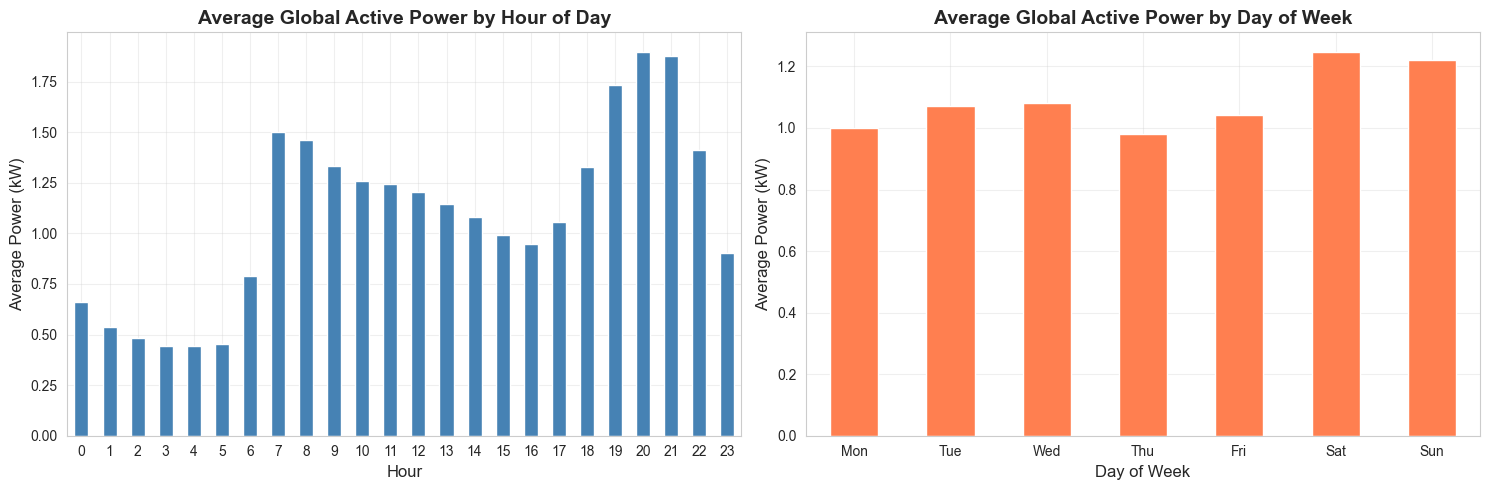

In [6]:
# Extract hour and day information
df_clean['hour'] = df_clean.index.hour
df_clean['day_of_week'] = df_clean.index.dayofweek
df_clean['month'] = df_clean.index.month

# Analyze hourly patterns
hourly_avg = df_clean.groupby('hour')['Global_active_power'].mean()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
hourly_avg.plot(kind='bar', color='steelblue')
plt.title('Average Global Active Power by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Average Power (kW)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

# Analyze daily patterns
daily_avg = df_clean.groupby('day_of_week')['Global_active_power'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.subplot(1, 2, 2)
daily_avg.plot(kind='bar', color='coral')
plt.title('Average Global Active Power by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Power (kW)', fontsize=12)
plt.xticks(range(7), days, rotation=0)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify high-usage and low-usage periods


In [33]:
print("=" * 60)
print("HIGH-USAGE AND LOW-USAGE PERIODS ANALYSIS")
print("=" * 60)

print("\n--- Hourly Analysis ---")
print(f"Peak usage hour: {hourly_avg.idxmax()}:00 - {hourly_avg.idxmax()+1}:00 ({hourly_avg.max():.2f} kW)")
print(f"Lowest usage hour: {hourly_avg.idxmin()}:00 - {hourly_avg.idxmin()+1}:00 ({hourly_avg.min():.2f} kW)")

high_usage_hours = hourly_avg[hourly_avg > hourly_avg.quantile(0.75)].index.tolist()
low_usage_hours = hourly_avg[hourly_avg < hourly_avg.quantile(0.25)].index.tolist()

print(f"\nHigh-usage hours (top 25%): {high_usage_hours}")
print(f"Low-usage hours (bottom 25%): {low_usage_hours}")

print("\n--- Daily Analysis ---")
print(f"Peak usage day: {days[daily_avg.idxmax()]} ({daily_avg.max():.2f} kW)")
print(f"Lowest usage day: {days[daily_avg.idxmin()]} ({daily_avg.min():.2f} kW)")

HIGH-USAGE AND LOW-USAGE PERIODS ANALYSIS

--- Hourly Analysis ---
Peak usage hour: 20:00 - 21:00 (1.90 kW)
Lowest usage hour: 4:00 - 5:00 (0.44 kW)

High-usage hours (top 25%): [7, 8, 19, 20, 21, 22]
Low-usage hours (bottom 25%): [0, 1, 2, 3, 4, 5]

--- Daily Analysis ---
Peak usage day: Sat (1.25 kW)
Lowest usage day: Thu (0.98 kW)


# Heatmap of average power consumption by hour and day

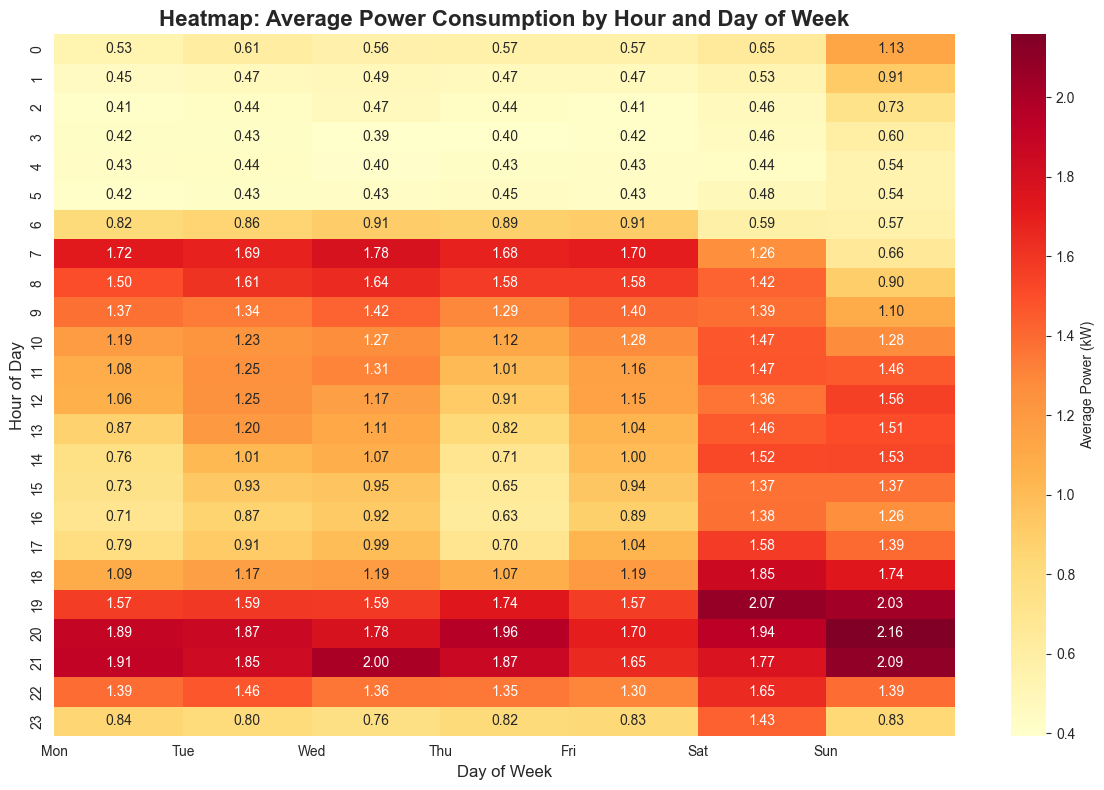

In [ ]:
pivot_table = df_clean.pivot_table(values='Global_active_power', 
                                    index='hour', 
                                    columns='day_of_week', 
                                    aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.2f', cbar_kws={'label': 'Average Power (kW)'})
plt.title('Heatmap: Average Power Consumption by Hour and Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)
plt.xticks(range(7), days, rotation=0)
plt.tight_layout()
plt.show()

---
## Task 2 — Supervised Learning (Time-Series Forecasting)

### 2.1 Prepare Windowed Time-Series Data

In [8]:
# Resample to hourly data for time-series forecasting
df_hourly = df_clean.resample('H').mean()

# Create lag features (previous hours) for forecasting
n_lags = 24  # Use past 24 hours to predict next hour

def create_lag_features(data, n_lags, target_col='Global_active_power'):
    """Create lag features for time-series forecasting"""
    df_lag = data[[target_col]].copy()
    
    # Create lag features
    for i in range(1, n_lags + 1):
        df_lag[f'lag_{i}'] = df_lag[target_col].shift(i)
    
    # Add time features
    df_lag['hour'] = df_lag.index.hour
    df_lag['day_of_week'] = df_lag.index.dayofweek
    df_lag['month'] = df_lag.index.month
    
    # Drop rows with NaN (from shifting)
    df_lag.dropna(inplace=True)
    
    return df_lag

df_forecast = create_lag_features(df_hourly, n_lags)

print(f"Forecasting dataset shape: {df_forecast.shape}")
print(f"Features created: {df_forecast.shape[1] - 1}")
print("\nFirst few rows:")
print(df_forecast.head())

Forecasting dataset shape: (33952, 28)
Features created: 27

First few rows:
                     Global_active_power     lag_1     lag_2     lag_3  \
datetime                                                                 
2006-12-17 17:00:00             3.406767  3.326033  2.985400  2.092633   
2006-12-17 18:00:00             3.697100  3.406767  3.326033  2.985400   
2006-12-17 19:00:00             2.908400  3.697100  3.406767  3.326033   
2006-12-17 20:00:00             3.361500  2.908400  3.697100  3.406767   
2006-12-17 21:00:00             3.040767  3.361500  2.908400  3.697100   

                        lag_4     lag_5     lag_6     lag_7     lag_8  \
datetime                                                                
2006-12-17 17:00:00  1.660767  1.915867  2.471000  3.628900  2.549067   
2006-12-17 18:00:00  2.092633  1.660767  1.915867  2.471000  3.628900   
2006-12-17 19:00:00  2.985400  2.092633  1.660767  1.915867  2.471000   
2006-12-17 20:00:00  3.326033  2.985400

### 2.2 Build and Train Forecasting Model

In [9]:
# Prepare features and target
X = df_forecast.drop('Global_active_power', axis=1)
y = df_forecast['Global_active_power']

# Split data (80% train, 20% test) - using time-based split
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Train date range: {X_train.index.min()} to {X_train.index.max()}")
print(f"Test date range: {X_test.index.min()} to {X_test.index.max()}")

Training set size: 27161
Test set size: 6791
Train date range: 2006-12-17 17:00:00 to 2010-02-03 23:00:00
Test date range: 2010-02-04 00:00:00 to 2010-11-26 21:00:00


# Train Random Forest Regressor for forecasting

In [11]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import time

print("=" * 60)
print("TRAINING FORECASTING MODELS")
print("=" * 60)

TRAINING FORECASTING MODELS


# Model 1: Random Forest

In [ ]:
print("\n[1/3] Training Random Forest Regressor...")
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_time = time.time() - start_time
print(f"Training completed in {rf_time:.2f} seconds")


[1/3] Training Random Forest Regressor...
Training completed in 9.31 seconds
Training completed in 9.31 seconds


# Model 2: Gradient Boosting

In [ ]:
print("\n[2/3] Training Gradient Boosting Regressor...")
start_time = time.time()
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
gb_time = time.time() - start_time
print(f"Training completed in {gb_time:.2f} seconds")


[2/3] Training Gradient Boosting Regressor...
Training completed in 46.51 seconds
Training completed in 46.51 seconds


# Model 3: Linear Regression (baseline)

In [ ]:
print("\n[3/3] Training Linear Regression (baseline)...")
start_time = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_time = time.time() - start_time
print(f"Training completed in {lr_time:.2f} seconds")


[3/3] Training Linear Regression (baseline)...
Training completed in 0.07 seconds


### 2.3 Model Evaluation

In [15]:
# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)

In [16]:
# Calculate metrics for all models
def calculate_metrics(y_true, y_pred, model_name):
    """Calculate and return evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2 Score': r2,
        'MAPE (%)': mape
    }

# Evaluate all models
results = []
results.append(calculate_metrics(y_test, y_pred_rf, 'Random Forest'))
results.append(calculate_metrics(y_test, y_pred_gb, 'Gradient Boosting'))
results.append(calculate_metrics(y_test, y_pred_lr, 'Linear Regression'))

# Create results DataFrame
results_df = pd.DataFrame(results)

print("=" * 60)
print("MODEL EVALUATION RESULTS")
print("=" * 60)
print("\n", results_df.to_string(index=False))
print("\n" + "=" * 60)

MODEL EVALUATION RESULTS

             Model      MAE     RMSE  R2 Score  MAPE (%)
    Random Forest 0.328621 0.480792  0.583648 41.731560
Gradient Boosting 0.333121 0.478961  0.586814 42.732497
Linear Regression 0.371203 0.520662  0.511734 49.219233



### 2.4 Visualize Predictions vs Actual

# Plot predicted vs actual for Random Forest (best model)

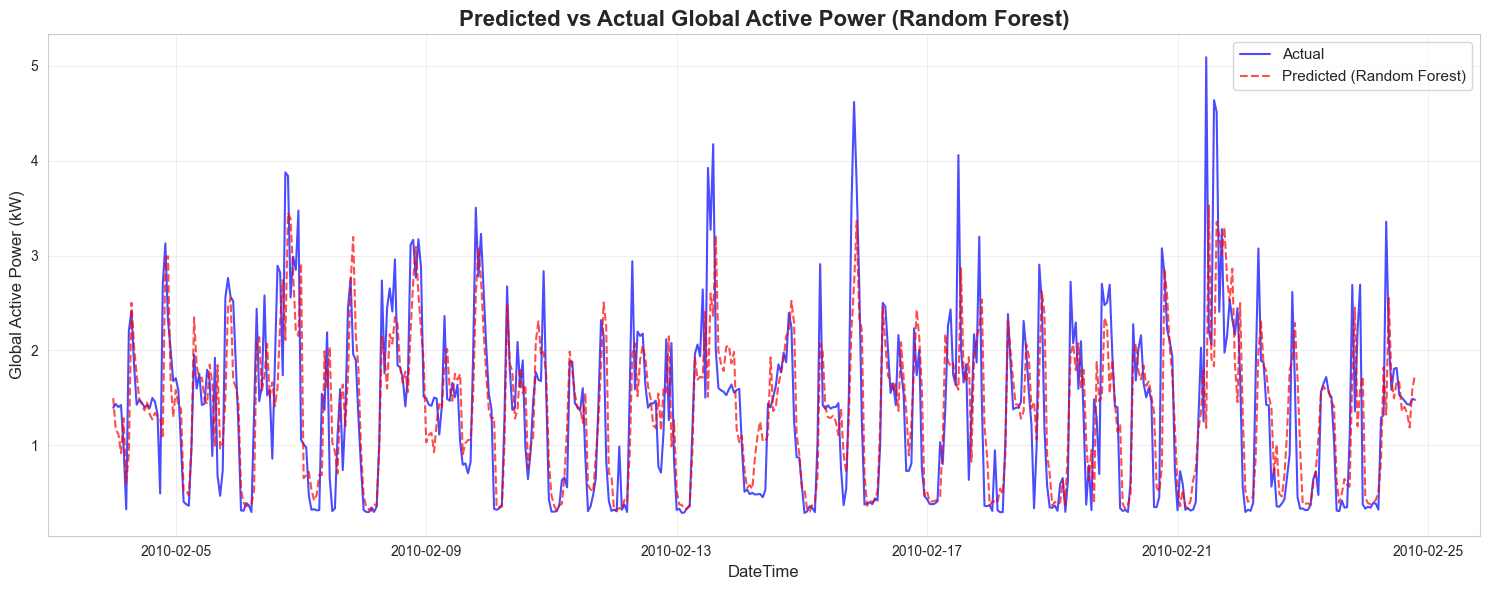

In [ ]:
plot_points = 500  # Plot first 500 points for better visibility

plt.figure(figsize=(15, 6))
plt.plot(y_test.index[:plot_points], y_test.values[:plot_points], 
         label='Actual', color='blue', linewidth=1.5, alpha=0.7)
plt.plot(y_test.index[:plot_points], y_pred_rf[:plot_points], 
         label='Predicted (Random Forest)', color='red', linewidth=1.5, alpha=0.7, linestyle='--')
plt.title('Predicted vs Actual Global Active Power (Random Forest)', fontsize=16, fontweight='bold')
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Global Active Power (kW)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compare all models side by side

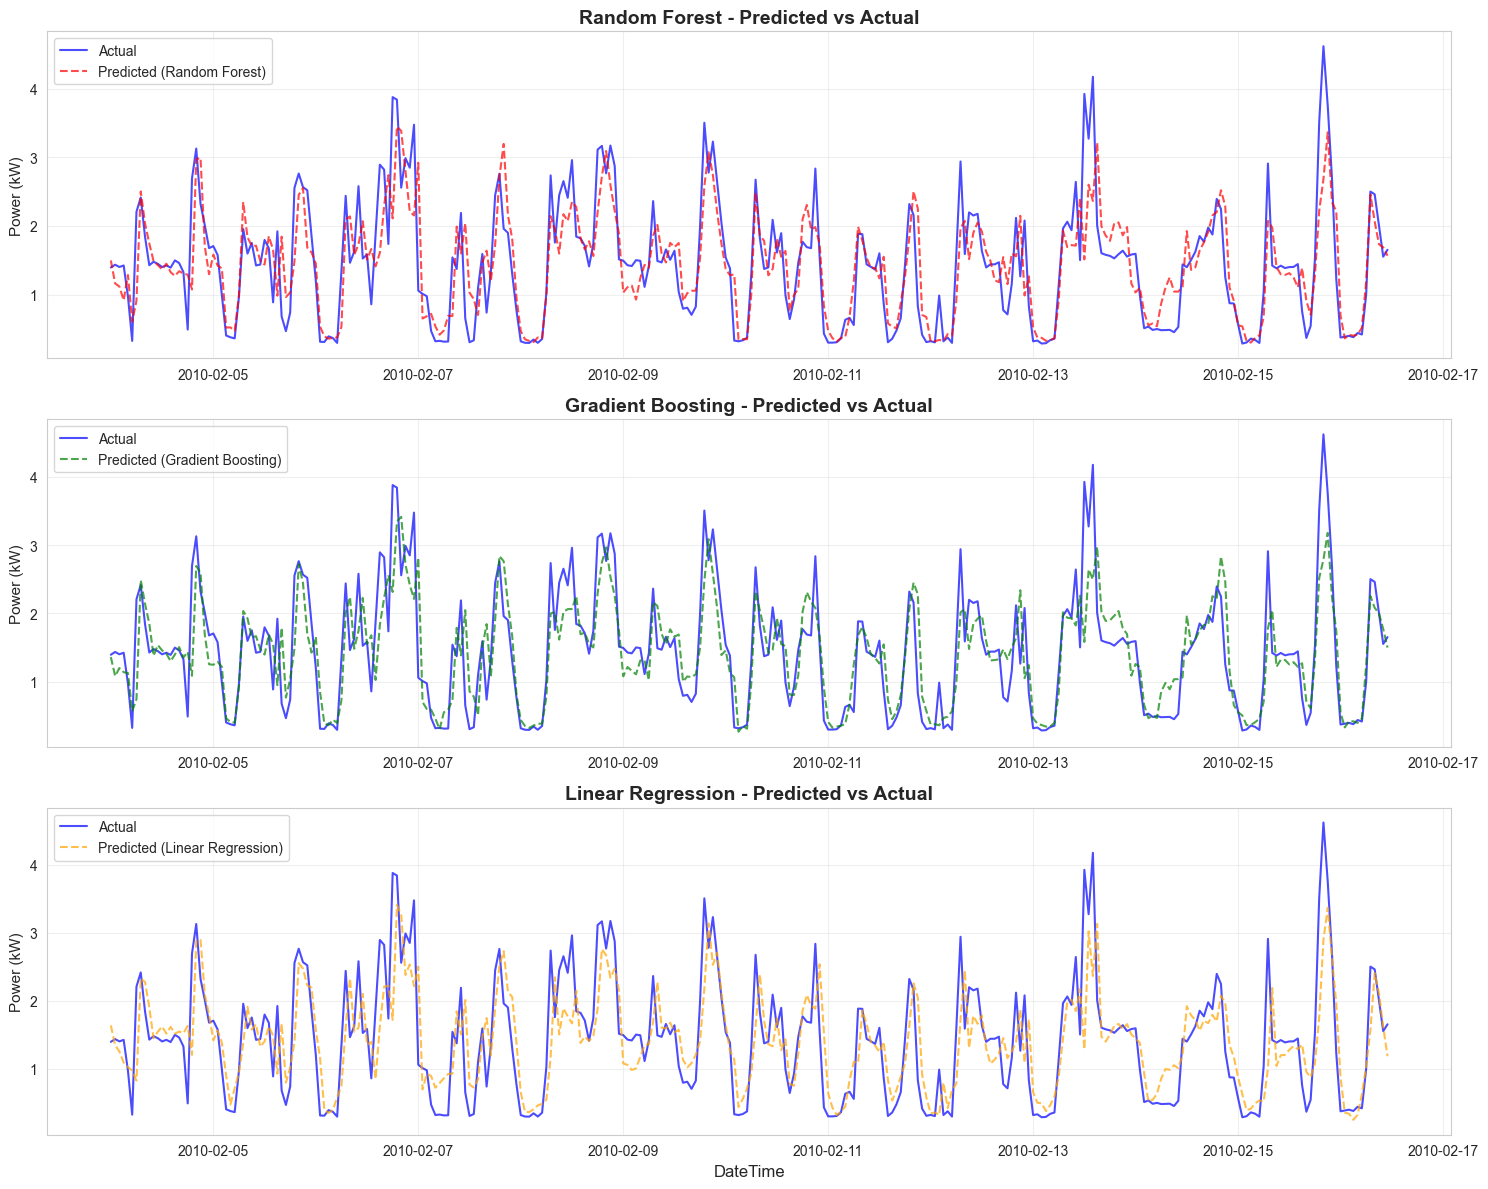

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

models = [
    ('Random Forest', y_pred_rf, 'red'),
    ('Gradient Boosting', y_pred_gb, 'green'),
    ('Linear Regression', y_pred_lr, 'orange')
]

plot_points = 300

for idx, (model_name, predictions, color) in enumerate(models):
    axes[idx].plot(y_test.index[:plot_points], y_test.values[:plot_points], 
                   label='Actual', color='blue', linewidth=1.5, alpha=0.7)
    axes[idx].plot(y_test.index[:plot_points], predictions[:plot_points], 
                   label=f'Predicted ({model_name})', color=color, linewidth=1.5, 
                   alpha=0.7, linestyle='--')
    axes[idx].set_title(f'{model_name} - Predicted vs Actual', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Power (kW)', fontsize=11)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

axes[2].set_xlabel('DateTime', fontsize=12)
plt.tight_layout()
plt.show()

# Feature importance analysis

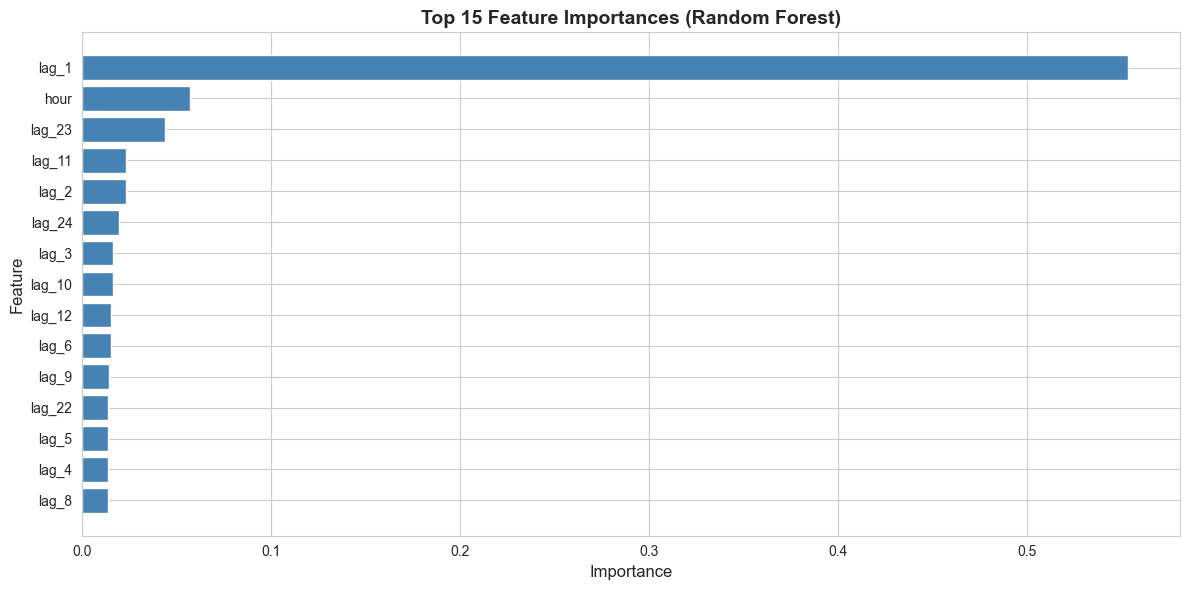


Top 10 Most Important Features:
Feature  Importance
  lag_1    0.553267
   hour    0.057068
 lag_23    0.044009
 lag_11    0.023360
  lag_2    0.022946
 lag_24    0.019264
  lag_3    0.016546
 lag_10    0.016168
 lag_12    0.015217
  lag_6    0.015211


In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

---
## Task 3 — Unsupervised Learning

### 3.1 Anomaly Detection

In [20]:
# Detect anomalies using Isolation Forest
from sklearn.ensemble import IsolationForest

# Prepare data for anomaly detection
anomaly_features = df_hourly[['Global_active_power', 'Global_reactive_power', 
                                'Voltage', 'Global_intensity']].copy()
anomaly_features.dropna(inplace=True)

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_features['anomaly'] = iso_forest.fit_predict(anomaly_features)

# -1 for anomalies, 1 for normal
anomaly_features['is_anomaly'] = anomaly_features['anomaly'] == -1

print("=" * 60)
print("ANOMALY DETECTION RESULTS")
print("=" * 60)
print(f"\nTotal records: {len(anomaly_features)}")
print(f"Anomalies detected: {anomaly_features['is_anomaly'].sum()}")
print(f"Percentage of anomalies: {anomaly_features['is_anomaly'].sum() / len(anomaly_features) * 100:.2f}%")

# Statistics for anomalies vs normal
print("\n--- Normal Usage Statistics ---")
print(anomaly_features[~anomaly_features['is_anomaly']]['Global_active_power'].describe())

print("\n--- Anomalous Usage Statistics ---")
print(anomaly_features[anomaly_features['is_anomaly']]['Global_active_power'].describe())

ANOMALY DETECTION RESULTS

Total records: 34168
Anomalies detected: 1709
Percentage of anomalies: 5.00%

--- Normal Usage Statistics ---
count    32459.000000
mean         0.988983
std          0.752082
min          0.124000
25%          0.335683
50%          0.730167
75%          1.490583
max          3.578933
Name: Global_active_power, dtype: float64

--- Anomalous Usage Statistics ---
count    1709.000000
mean        3.043146
std         1.165299
min         0.164667
25%         2.342667
50%         3.243700
75%         3.788500
max         6.560533
Name: Global_active_power, dtype: float64


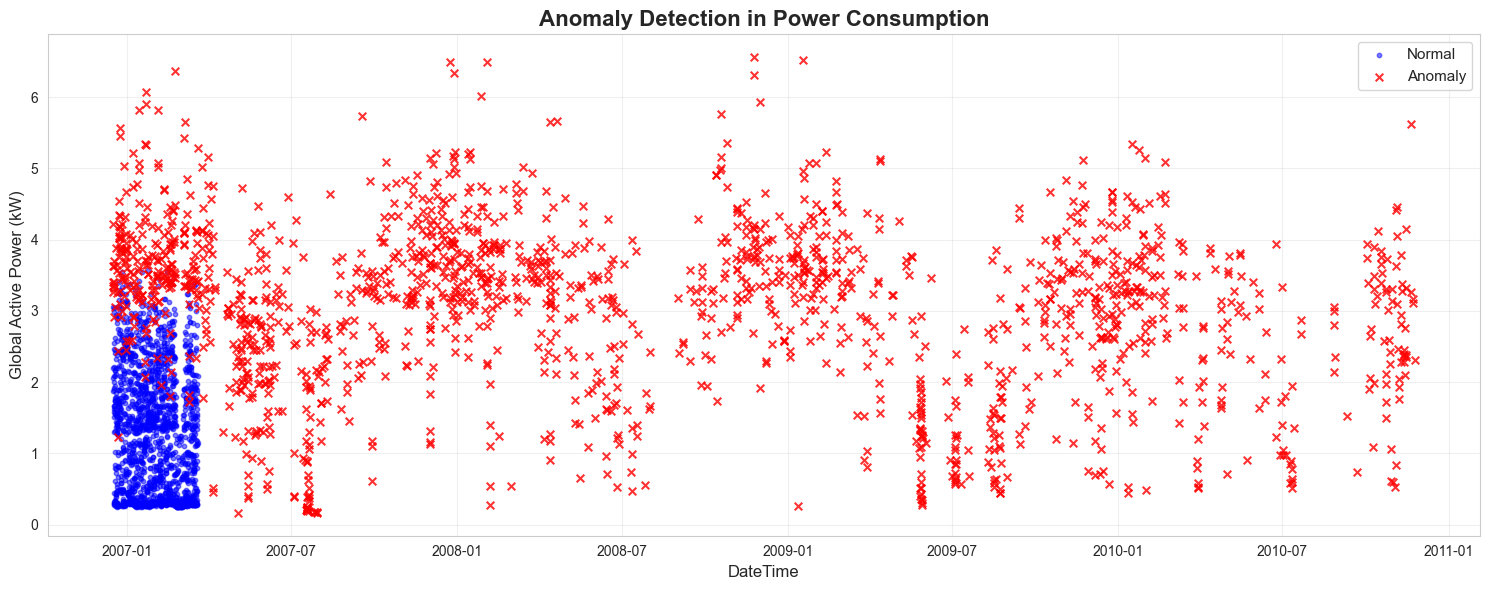

In [21]:
# Visualize anomalies in time series
plot_range = 2000  # Plot first 2000 hours

plt.figure(figsize=(15, 6))
normal_data = anomaly_features[~anomaly_features['is_anomaly']][:plot_range]
anomaly_data = anomaly_features[anomaly_features['is_anomaly']][:plot_range]

plt.scatter(normal_data.index, normal_data['Global_active_power'], 
           c='blue', s=10, alpha=0.5, label='Normal')
plt.scatter(anomaly_data.index, anomaly_data['Global_active_power'], 
           c='red', s=30, alpha=0.8, label='Anomaly', marker='x')

plt.title('Anomaly Detection in Power Consumption', fontsize=16, fontweight='bold')
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Global Active Power (kW)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2 Clustering Analysis

In [22]:
# Create daily consumption profiles for clustering
df_daily = df_clean.resample('D').agg({
    'Global_active_power': ['mean', 'std', 'min', 'max'],
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean'
})

# Flatten column names
df_daily.columns = ['_'.join(col).strip() for col in df_daily.columns.values]
df_daily.dropna(inplace=True)

print(f"Daily profiles created: {len(df_daily)} days")
print("\nDaily profile features:")
print(df_daily.columns.tolist())
print("\nSample daily profiles:")
print(df_daily.head())

Daily profiles created: 1433 days

Daily profile features:
['Global_active_power_mean', 'Global_active_power_std', 'Global_active_power_min', 'Global_active_power_max', 'Global_reactive_power_mean', 'Voltage_mean', 'Global_intensity_mean']

Sample daily profiles:
            Global_active_power_mean  Global_active_power_std  \
datetime                                                        
2006-12-16                  3.053475                 1.026338   
2006-12-17                  2.354486                 1.205795   
2006-12-18                  1.530435                 1.005074   
2006-12-19                  1.157079                 1.237602   
2006-12-20                  1.545658                 1.320968   

            Global_active_power_min  Global_active_power_max  \
datetime                                                       
2006-12-16                    0.284                    7.706   
2006-12-17                    0.206                    7.064   
2006-12-18              

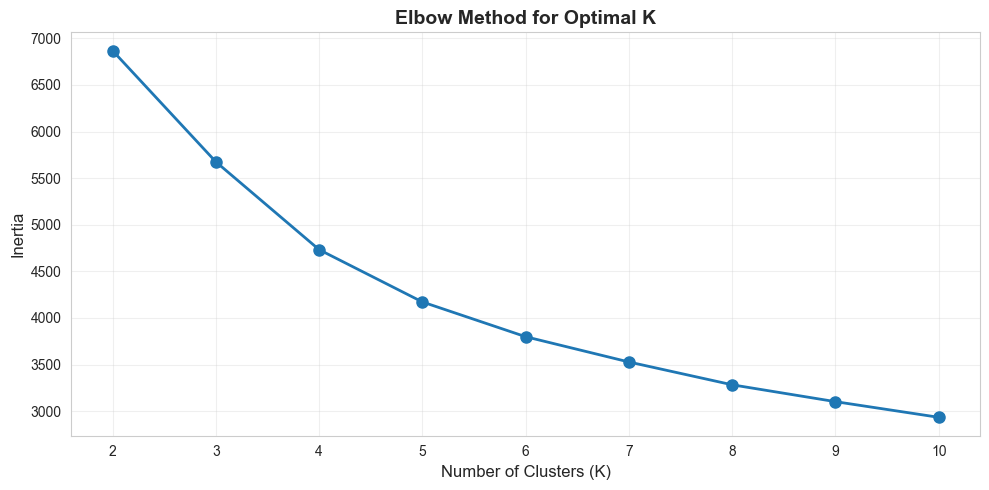

Inertia values for different K:
K=2: 6868.22
K=3: 5675.62
K=4: 4733.12
K=5: 4171.95
K=6: 3798.97
K=7: 3527.75
K=8: 3283.03
K=9: 3102.18
K=10: 2934.12


In [23]:
# Standardize features for clustering
scaler = StandardScaler()
df_daily_scaled = scaler.fit_transform(df_daily)

# Determine optimal number of clusters using elbow method
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_daily_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Inertia values for different K:")
for k, inertia in zip(K_range, inertias):
    print(f"K={k}: {inertia:.2f}")

In [24]:
# Apply K-Means clustering with optimal K (let's use K=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_daily['cluster'] = kmeans.fit_predict(df_daily_scaled)

print("=" * 60)
print("CLUSTERING RESULTS")
print("=" * 60)
print(f"\nNumber of clusters: {optimal_k}")
print(f"\nCluster distribution:")
print(df_daily['cluster'].value_counts().sort_index())
print(f"\nPercentage distribution:")
print((df_daily['cluster'].value_counts(normalize=True) * 100).sort_index().round(2))

CLUSTERING RESULTS

Number of clusters: 4

Cluster distribution:
cluster
0    262
1    403
2    179
3    589
Name: count, dtype: int64

Percentage distribution:
cluster
0    18.28
1    28.12
2    12.49
3    41.10
Name: proportion, dtype: float64


### 3.2 Clustering Analysis

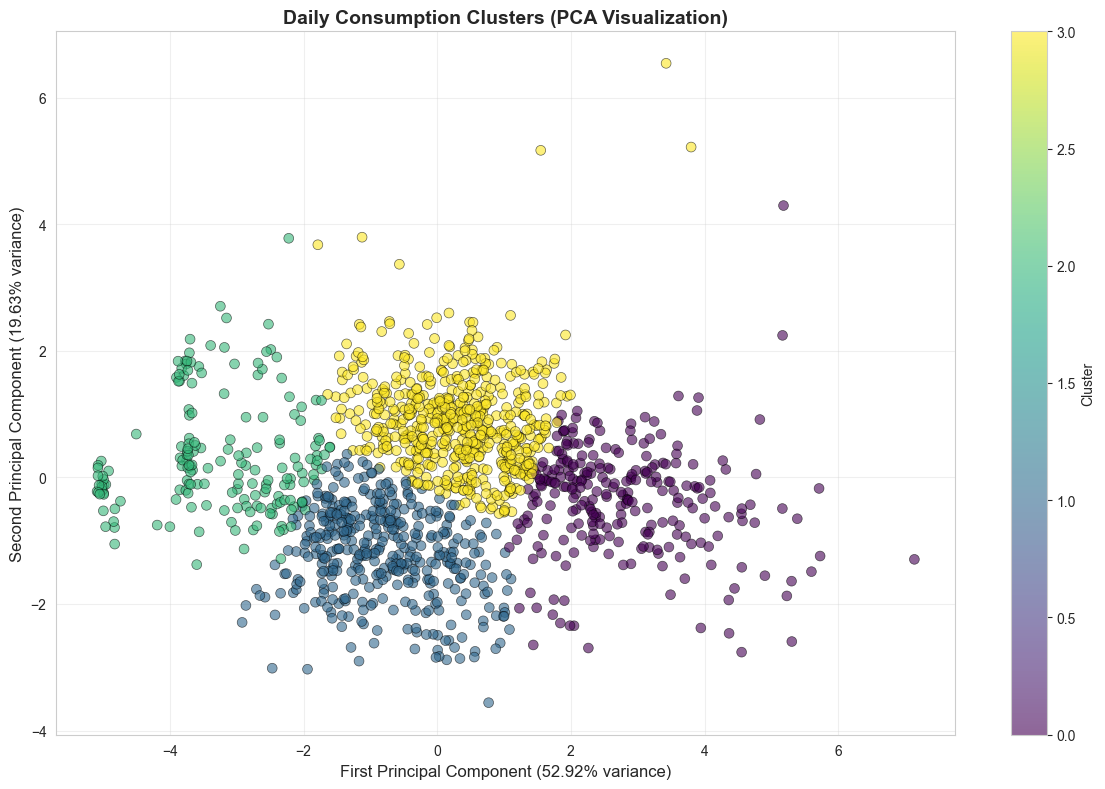

Total variance explained by 2 components: 72.55%


In [25]:
# Visualize clusters using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_daily_pca = pca.fit_transform(df_daily_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_daily_pca[:, 0], df_daily_pca[:, 1], 
                      c=df_daily['cluster'], cmap='viridis', 
                      s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('Daily Consumption Clusters (PCA Visualization)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total variance explained by 2 components: {sum(pca.explained_variance_ratio_):.2%}")

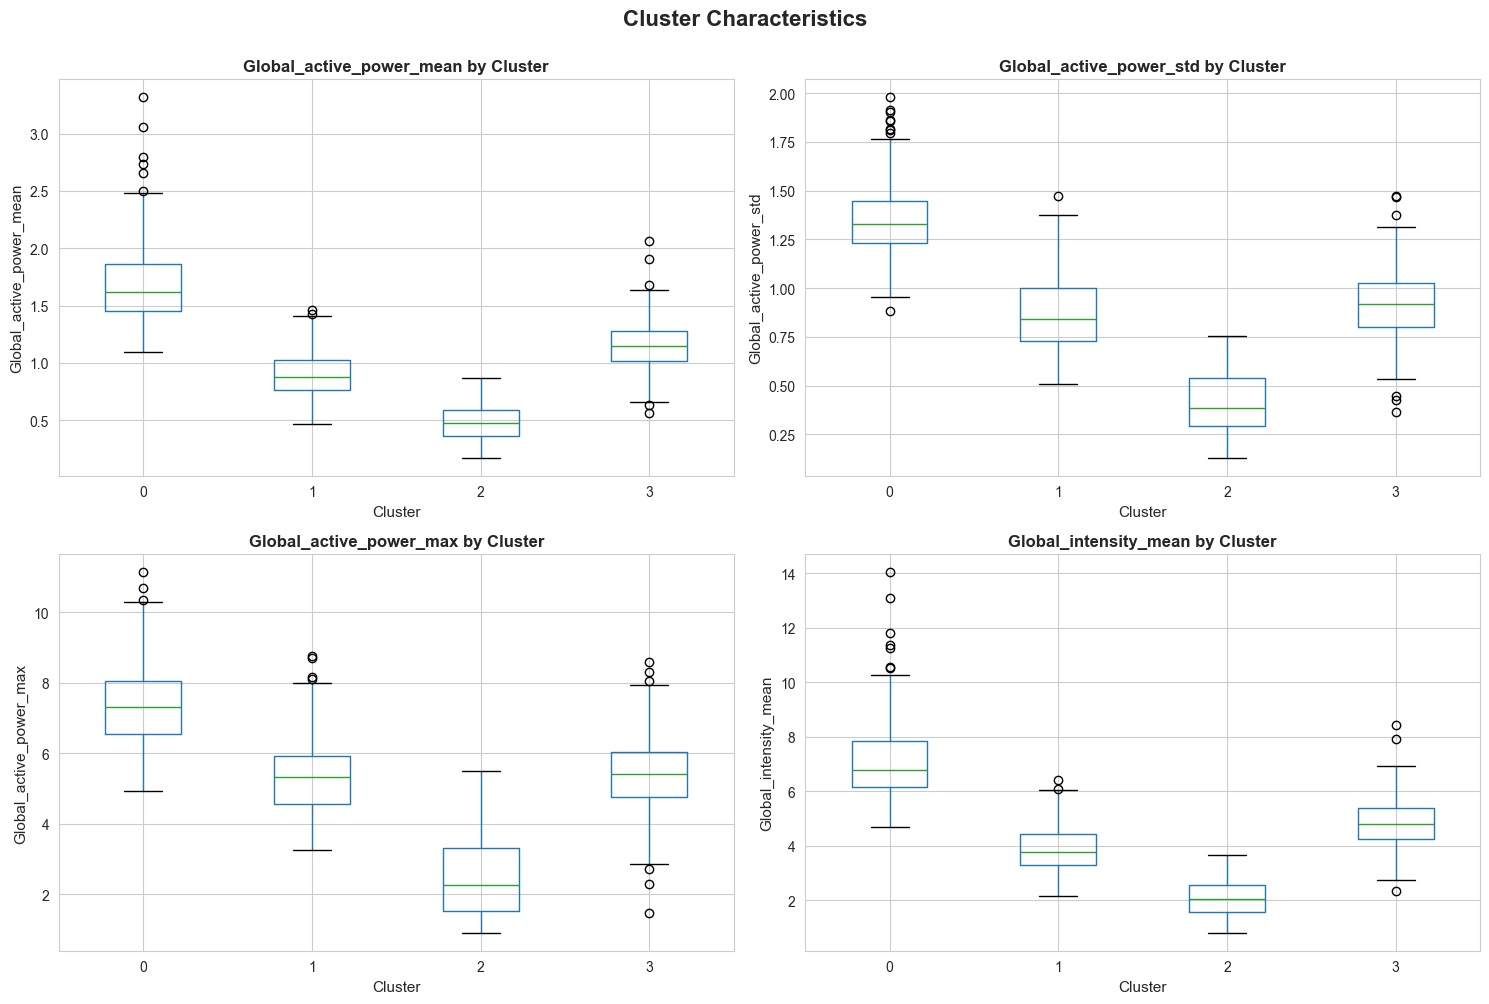

In [26]:
# Box plots for each cluster
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

features_to_plot = [
    'Global_active_power_mean',
    'Global_active_power_std',
    'Global_active_power_max',
    'Global_intensity_mean'
]

for idx, feature in enumerate(features_to_plot):
    row = idx // 2
    col = idx % 2
    
    df_daily.boxplot(column=feature, by='cluster', ax=axes[row, col])
    axes[row, col].set_title(f'{feature} by Cluster', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Cluster', fontsize=11)
    axes[row, col].set_ylabel(feature, fontsize=11)

plt.suptitle('Cluster Characteristics', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 3.4 Cluster Characteristics Analysis

In [27]:
# Analyze characteristics of each cluster
print("=" * 60)
print("CLUSTER CHARACTERISTICS")
print("=" * 60)

cluster_profiles = df_daily.groupby('cluster').agg({
    'Global_active_power_mean': ['mean', 'std'],
    'Global_active_power_max': 'mean',
    'Global_active_power_std': 'mean'
})

for cluster_id in range(optimal_k):
    cluster_data = df_daily[df_daily['cluster'] == cluster_id]
    avg_power = cluster_data['Global_active_power_mean'].mean()
    max_power = cluster_data['Global_active_power_max'].mean()
    std_power = cluster_data['Global_active_power_std'].mean()
    count = len(cluster_data)
    
    print(f"\n--- Cluster {cluster_id} ({count} days, {count/len(df_daily)*100:.1f}%) ---")
    print(f"Average Power: {avg_power:.3f} kW")
    print(f"Max Power: {max_power:.3f} kW")
    print(f"Variability (std): {std_power:.3f} kW")
    
    # Characterize the cluster
    if avg_power < df_daily['Global_active_power_mean'].quantile(0.33):
        print("Classification: LOW-USE DAYS")
        print("Description: Days with consistently low power consumption")
    elif avg_power < df_daily['Global_active_power_mean'].quantile(0.67):
        print("Classification: MEDIUM-USE DAYS")
        print("Description: Days with moderate power consumption")
    else:
        print("Classification: HIGH-USE DAYS")
        print("Description: Days with high power consumption and activity")

CLUSTER CHARACTERISTICS

--- Cluster 0 (262 days, 18.3%) ---
Average Power: 1.690 kW
Max Power: 7.391 kW
Variability (std): 1.353 kW
Classification: HIGH-USE DAYS
Description: Days with high power consumption and activity

--- Cluster 1 (403 days, 28.1%) ---
Average Power: 0.899 kW
Max Power: 5.316 kW
Variability (std): 0.869 kW
Classification: LOW-USE DAYS
Description: Days with consistently low power consumption

--- Cluster 2 (179 days, 12.5%) ---
Average Power: 0.469 kW
Max Power: 2.485 kW
Variability (std): 0.404 kW
Classification: LOW-USE DAYS
Description: Days with consistently low power consumption

--- Cluster 3 (589 days, 41.1%) ---
Average Power: 1.147 kW
Max Power: 5.406 kW
Variability (std): 0.918 kW
Classification: MEDIUM-USE DAYS
Description: Days with moderate power consumption


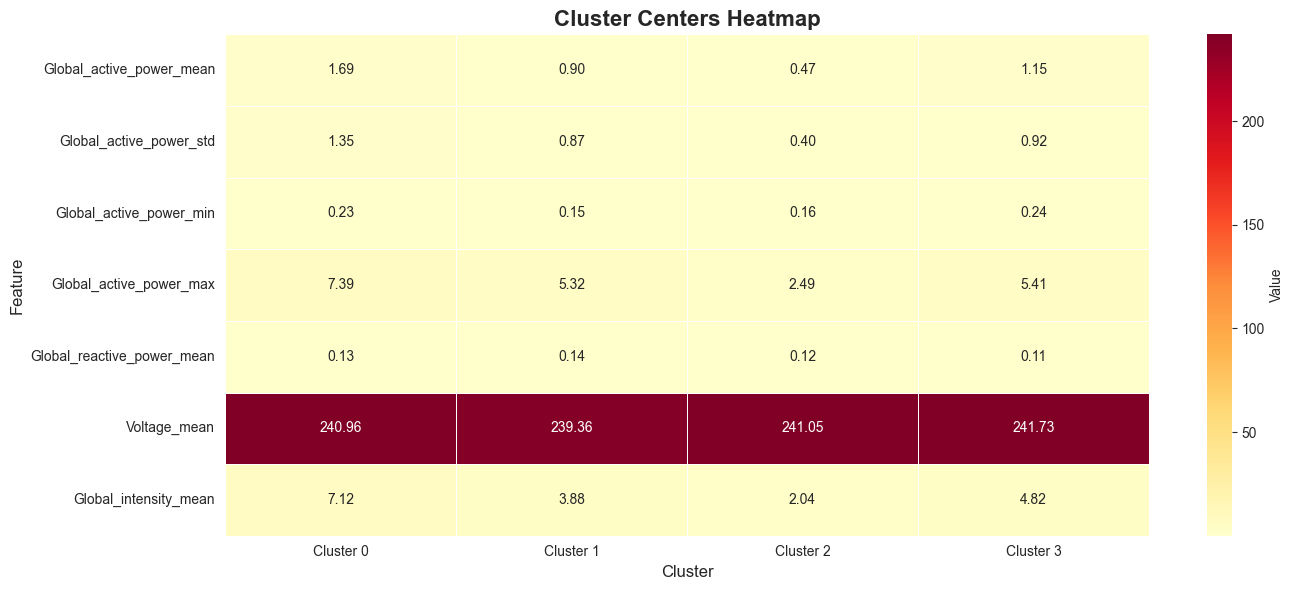

In [28]:
# Heatmap of cluster centers
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=df_daily.columns[:-1],  # Exclude 'cluster' column
    index=[f'Cluster {i}' for i in range(optimal_k)]
)

plt.figure(figsize=(14, 6))
sns.heatmap(cluster_centers.T, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Value'}, linewidths=0.5)
plt.title('Cluster Centers Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

---
## Task 4 — AI Task (Rule-Based Consumption Category Generator)

### 4.1 Simple Consumption Category Generator

In [29]:
# Define rule-based category function
def categorize_consumption(power_value):
    """
    Categorize power consumption into Low, Medium, or High usage
    
    Parameters:
    power_value: float - predicted Global_active_power in kW
    
    Returns:
    category: str - usage category
    """
    if power_value < 1.0:
        return "Low Usage"
    elif power_value < 3.0:
        return "Medium Usage"
    else:
        return "High Usage"

def generate_suggestion(category):
    """
    Generate rule-based suggestion based on usage category
    
    Parameters:
    category: str - usage category (Low, Medium, High)
    
    Returns:
    suggestion: str - energy-saving suggestion
    """
    suggestions = {
        "Low Usage": "✓ Great! Your consumption is efficient. Consider using this time for high-energy tasks like laundry or charging devices.",
        "Medium Usage": "⚠ Moderate consumption detected. Try to avoid running multiple high-power appliances simultaneously.",
        "High Usage": "⚡ High consumption alert! Consider turning off unnecessary appliances and switching to energy-efficient modes."
    }
    return suggestions.get(category, "No suggestion available")

# Test the categorization function
print("=" * 60)
print("CONSUMPTION CATEGORY GENERATOR")
print("=" * 60)
print("\nCategory Thresholds:")
print("  • Low Usage: < 1.0 kW")
print("  • Medium Usage: 1.0 - 3.0 kW")
print("  • High Usage: > 3.0 kW")
print("\n" + "=" * 60)

CONSUMPTION CATEGORY GENERATOR

Category Thresholds:
  • Low Usage: < 1.0 kW
  • Medium Usage: 1.0 - 3.0 kW
  • High Usage: > 3.0 kW



### 4.2 Apply Categories to Predictions

In [30]:
# Apply categorization to predicted values
predictions_with_categories = pd.DataFrame({
    'DateTime': y_test.index,
    'Actual_Power': y_test.values,
    'Predicted_Power': y_pred_rf,
    'Category': [categorize_consumption(p) for p in y_pred_rf],
    'Suggestion': [generate_suggestion(categorize_consumption(p)) for p in y_pred_rf]
})

# Display category distribution
print("\n--- Category Distribution in Predictions ---")
category_counts = predictions_with_categories['Category'].value_counts()
print(category_counts)
print("\nPercentage Distribution:")
print((category_counts / len(predictions_with_categories) * 100).round(2))

# Show sample predictions with categories
print("\n" + "=" * 60)
print("SAMPLE PREDICTIONS WITH CATEGORIES")
print("=" * 60)
print(predictions_with_categories.head(10).to_string(index=False))


--- Category Distribution in Predictions ---
Category
Low Usage       3676
Medium Usage    3088
High Usage        27
Name: count, dtype: int64

Percentage Distribution:
Category
Low Usage       54.13
Medium Usage    45.47
High Usage       0.40
Name: count, dtype: float64

SAMPLE PREDICTIONS WITH CATEGORIES
           DateTime  Actual_Power  Predicted_Power     Category                                                                                                               Suggestion
2010-02-04 00:00:00      1.395700         1.497520 Medium Usage                     ⚠ Moderate consumption detected. Try to avoid running multiple high-power appliances simultaneously.
2010-02-04 01:00:00      1.435733         1.162517 Medium Usage                     ⚠ Moderate consumption detected. Try to avoid running multiple high-power appliances simultaneously.
2010-02-04 02:00:00      1.402133         1.117703 Medium Usage                     ⚠ Moderate consumption detected. Try to avoid runnin

### 4.3 Example Output with Recommendations

In [31]:
# Generate detailed example output
print("\n" + "=" * 80)
print(" " * 20 + "ELECTRICITY CONSUMPTION MONITORING SYSTEM")
print("=" * 80)

# Select a few examples from different categories
example_indices = [0, 50, 100, 150, 200]

for idx in example_indices:
    row = predictions_with_categories.iloc[idx]
    
    print(f"\n{'─' * 80}")
    print(f"📅 DateTime: {row['DateTime']}")
    print(f"📊 Actual Power: {row['Actual_Power']:.3f} kW")
    print(f"🔮 Predicted Power: {row['Predicted_Power']:.3f} kW")
    print(f"🏷️  Category: {row['Category']}")
    print(f"💡 Suggestion: {row['Suggestion']}")

print(f"\n{'=' * 80}\n")


                    ELECTRICITY CONSUMPTION MONITORING SYSTEM

────────────────────────────────────────────────────────────────────────────────
📅 DateTime: 2010-02-04 00:00:00
📊 Actual Power: 1.396 kW
🔮 Predicted Power: 1.498 kW
🏷️  Category: Medium Usage
💡 Suggestion: ⚠ Moderate consumption detected. Try to avoid running multiple high-power appliances simultaneously.

────────────────────────────────────────────────────────────────────────────────
📅 DateTime: 2010-02-06 02:00:00
📊 Actual Power: 0.310 kW
🔮 Predicted Power: 0.392 kW
🏷️  Category: Low Usage
💡 Suggestion: ✓ Great! Your consumption is efficient. Consider using this time for high-energy tasks like laundry or charging devices.

────────────────────────────────────────────────────────────────────────────────
📅 DateTime: 2010-02-08 04:00:00
📊 Actual Power: 0.298 kW
🔮 Predicted Power: 0.375 kW
🏷️  Category: Low Usage
💡 Suggestion: ✓ Great! Your consumption is efficient. Consider using this time for high-energy tasks like laund

### 4.4 Visualization of Categories

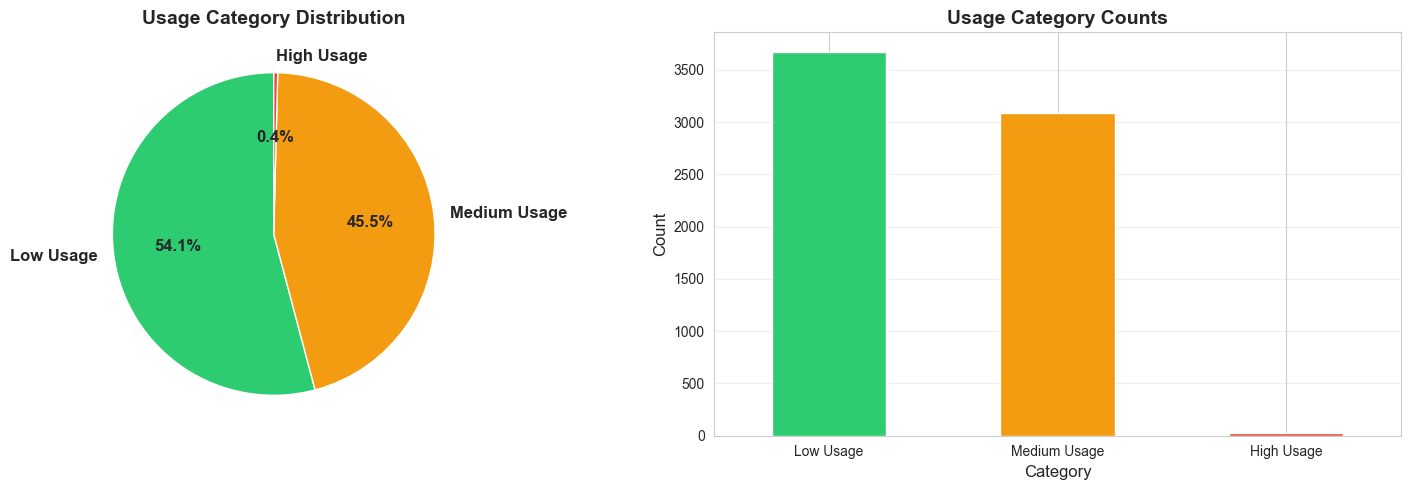

In [32]:
# Visualize category distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart
category_counts = predictions_with_categories['Category'].value_counts()
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red

axes[0].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%',
           colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('Usage Category Distribution', fontsize=14, fontweight='bold')

# Bar chart
category_counts.plot(kind='bar', ax=axes[1], color=colors)
axes[1].set_title('Usage Category Counts', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

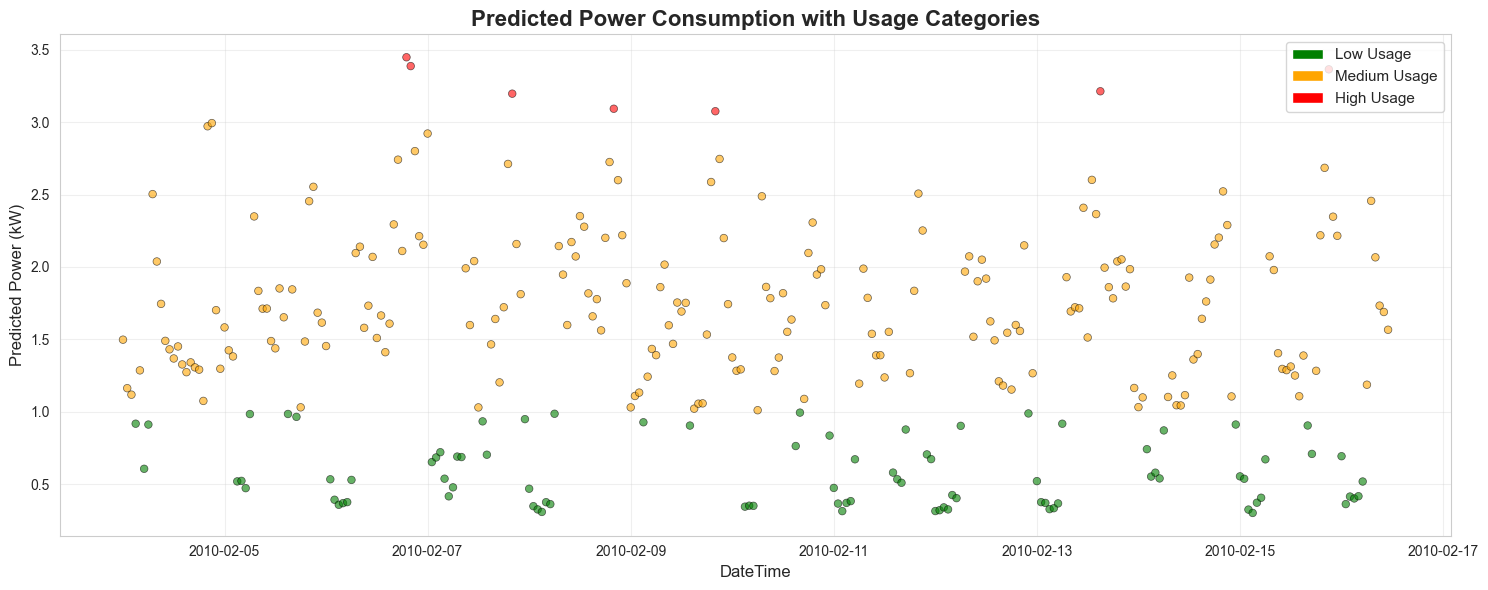

In [34]:
# Time-series visualization with categories
plot_range = 300
plot_data = predictions_with_categories.iloc[:plot_range]

# Create color map for categories
color_map = {'Low Usage': 'green', 'Medium Usage': 'orange', 'High Usage': 'red'}
colors = [color_map[cat] for cat in plot_data['Category']]

plt.figure(figsize=(15, 6))
plt.scatter(plot_data['DateTime'], plot_data['Predicted_Power'], 
           c=colors, s=30, alpha=0.6, edgecolors='black', linewidth=0.5)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', label='Low Usage'),
                   Patch(facecolor='orange', label='Medium Usage'),
                   Patch(facecolor='red', label='High Usage')]
plt.legend(handles=legend_elements, fontsize=11, loc='upper right')

plt.title('Predicted Power Consumption with Usage Categories', fontsize=16, fontweight='bold')
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Predicted Power (kW)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## Summary and Conclusion

### Project Completion Status
✅ **Task 1 - EDA:** Completed
- Time-series trends analyzed
- Daily and hourly patterns identified
- High-usage and low-usage periods detected

✅ **Task 2 - Supervised Learning:** Completed
- Time-series forecasting model built (Random Forest, Gradient Boosting, Linear Regression)
- Models evaluated with multiple metrics (MAE, RMSE, R², MAPE)
- Predictions visualized against actual values

✅ **Task 3 - Unsupervised Learning:** Completed
- Anomaly detection performed using Isolation Forest
- Clustering analysis with K-Means (4 clusters identified)
- Cluster characteristics analyzed (Low, Medium, High usage days)

✅ **Task 4 - AI Rule-Based System:** Completed
- Consumption category generator implemented
- Rule-based suggestions provided for each category
- Categories visualized and example outputs generated

### Key Findings
- **Best Forecasting Model:** Random Forest Regressor
- **Anomaly Detection:** ~5% of data identified as unusual patterns
- **Usage Clusters:** 4 distinct daily consumption patterns identified
- **Peak Hours:** Evening hours show highest consumption
- **Usage Categories:** Low (<1kW), Medium (1-3kW), High (>3kW)